In [880]:
import numpy as np
import pandas as pd
from functools import reduce
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
#pd.set_option("precision",4)

# Market Data for US

In [881]:
df_CRSP_market_daily=pd.read_csv('../data/CRSP/CRSP Daily Index Built on Market Capitalization.csv',\
index_col=0,parse_dates=True)

In [882]:
df_CRSP_market_daily =df_CRSP_market_daily[['vwretd']]['2001-01-01':'2020-12-31']

In [883]:
df_AQR_risk_free_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='RF',header=18,index_col=0,parse_dates=True)
df_AQR_risk_free_daily= df_AQR_risk_free_daily['2001-01-01':'2020-12-31']

In [892]:
df_AQR_MKT_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='MKT',header=18,index_col=0,parse_dates=True)
df_AQR_MKT_daily= df_AQR_MKT_daily['2001-01-01':'2020-12-31']

In [893]:
df_FF_5=pd.read_csv('../data/FF_Factors/F-F_Research_Data_5_Factors_2x3_daily.csv',index_col=0,parse_dates=True)
df_FF_5 = df_FF_5['2001-01-01':'2020-12-31']/100

In [894]:
df_FF_5

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2001-01-02,-0.0352,0.0039,0.0165,0.0158,0.0161,0.00026
2001-01-03,0.0539,-0.0065,-0.0439,-0.0266,-0.0594,0.00026
2001-01-04,-0.0130,0.0097,-0.0030,0.0052,-0.0080,0.00026
2001-01-05,-0.0298,0.0071,0.0238,0.0190,0.0231,0.00026
2001-01-08,-0.0036,-0.0043,0.0126,0.0098,0.0067,0.00026
...,...,...,...,...,...,...
2020-12-24,0.0021,-0.0043,-0.0017,0.0024,-0.0005,0.00000
2020-12-28,0.0046,-0.0065,0.0032,0.0146,0.0050,0.00000
2020-12-29,-0.0040,-0.0142,0.0024,0.0075,-0.0028,0.00000


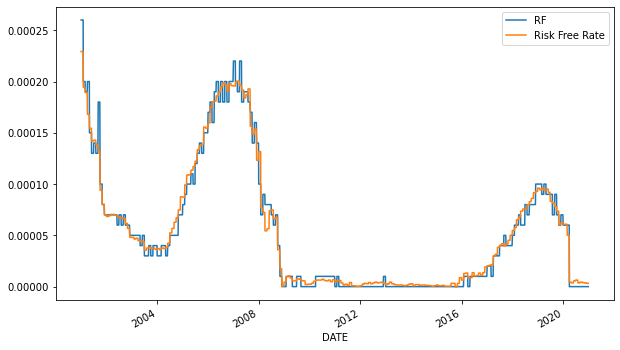

In [895]:
fig, ax =plt.subplots(figsize=(10,6))

df_FF_5.RF.plot(ax=ax)
(df_AQR_risk_free_daily).plot(ax=ax)

plt.legend()

In [896]:
dfs_market_merged=[df_FF_5[['Mkt-RF']],df_CRSP_market_daily[['vwretd']],df_AQR_MKT_daily[['USA']]]
dfs_market_merged=reduce(lambda x,y:pd.merge(x,y,left_index=True, right_index=True),dfs_market_merged)

<AxesSubplot:>

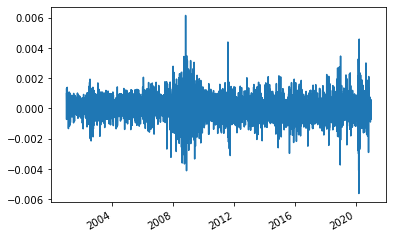

In [897]:
(dfs_market_merged['vwretd']-dfs_market_merged['Mkt-RF']).plot()

In [898]:
dfs_market_merged

,Mkt-RF,vwretd,USA
2001-01-02,-0.0352,-0.034230,-0.034543
2001-01-03,0.0539,0.053170,0.053313
2001-01-04,-0.0130,-0.011674,-0.010935
2001-01-05,-0.0298,-0.028909,-0.028499
2001-01-08,-0.0036,-0.003410,-0.003914
...,...,...,...
2020-12-24,0.0021,0.002332,0.002347
2020-12-28,0.0046,0.003870,0.003893
2020-12-29,-0.0040,-0.003649,-0.003812
2020-12-30,0.0027,0.003281,0.003364


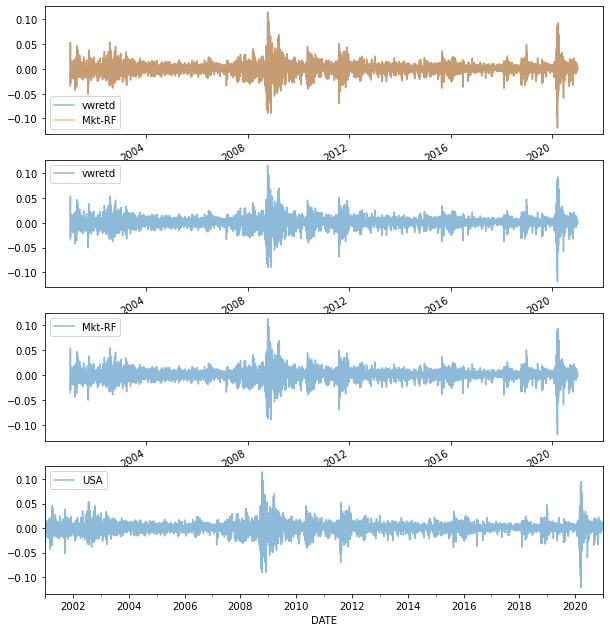

In [899]:
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(10,12))

(df_CRSP_market_daily.vwretd).plot(ax=ax[0],alpha=0.5)
df_FF_5['Mkt-RF'].plot(ax=ax[0],alpha=0.5)

(df_CRSP_market_daily.vwretd).plot(ax=ax[1],alpha=0.5)

df_FF_5['Mkt-RF'].plot(ax=ax[2],alpha=0.5)

df_AQR_MKT_daily['USA'].plot(ax=ax[3],alpha=0.5)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

# Construct the Table 3

In [1068]:
def get_alpha(df, factors,portfolio):
    x = df[factors].copy()
    x = sm.add_constant(x)
    results = sm.OLS(df_Port_FF5[portfolio], x).fit(cov_type='HC1')
    return results.params[0],results.params[1],results.tvalues[0]

In [1069]:
df_betas=pd.read_pickle('../output/US/Portfolio Beta and Return Daily/beta.pickle')
df_returns=pd.read_pickle('../output/US/Portfolio Beta and Return Daily/return.pickle')
df_betas = df_betas.astype('float64')
df_returns = df_returns.astype('float64')

<AxesSubplot:>

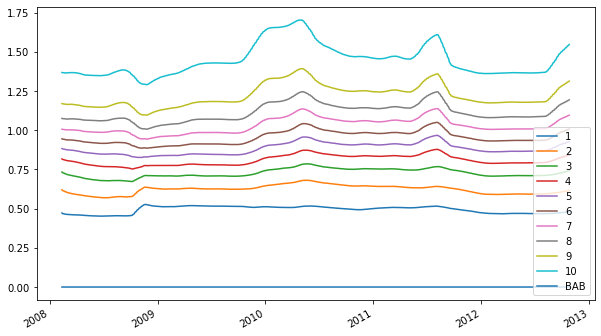

In [1070]:
df_betas.rolling(30).mean().plot(figsize=(10,6))

<AxesSubplot:>

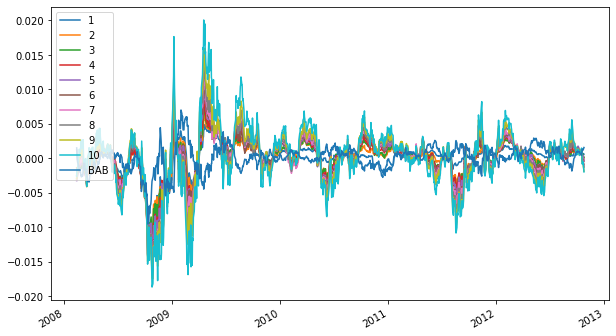

In [1071]:
df_returns.rolling(30).mean().plot(figsize=(10,6))

In [1072]:
df_table_3=pd.DataFrame(index=['Excess Return','CAPM alpha','Three-factor alpha','Four-factor alpha',
                   'Five-factor alpha','Beta(ex ante)','Beta(realized)','Volatility','Sharpe Ratio'],
            columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','BAB'])

In [1073]:
df_table_4=pd.DataFrame(index=['CAPM alpha','Three-factor alpha','Four-factor alpha',
                   'Five-factor alpha'],
            columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','BAB'])

In [1074]:
df_Port_FF5=df_returns.merge(df_FF_5,left_index=True,right_index=True)
df_Port_FF5 = df_Port_FF5.dropna()

In [1075]:
df_Port_FF5 = df_Port_FF5['2009-01-01':'2014-01-01']

In [1076]:
df_Port_FF5.index

DatetimeIndex(['2009-01-02', '2009-01-05', '2009-01-06', '2009-01-07',
               '2009-01-08', '2009-01-09', '2009-01-12', '2009-01-13',
               '2009-01-14', '2009-01-15',
               ...
               '2012-10-12', '2012-10-15', '2012-10-16', '2012-10-17',
               '2012-10-18', '2012-10-19', '2012-10-22', '2012-10-23',
               '2012-10-24', '2012-10-25'],
              dtype='datetime64[ns]', length=963, freq=None)

In [1077]:
df_Port_FF5

,1,2,3,4,5,6,7,8,9,10,BAB,Mkt-RF,SMB,HML,RMW,CMA,RF
2009-01-02,0.027545,0.023646,0.023103,0.028013,0.034537,0.030394,0.025675,0.028508,0.038805,0.042193,0.010155,0.0311,-0.0136,-0.0042,-0.0020,-0.0015,0.0
2009-01-05,0.016488,0.013279,0.007245,0.008639,0.007574,0.004934,0.005089,0.011262,0.013678,0.020106,0.007909,-0.0028,0.0036,-0.0115,-0.0037,-0.0055,0.0
2009-01-06,0.018553,0.019232,0.016392,0.017807,0.027616,0.024362,0.028865,0.031070,0.036421,0.056896,-0.006464,0.0087,0.0113,0.0087,-0.0048,-0.0012,0.0
2009-01-07,-0.004602,-0.009844,-0.012357,-0.021955,-0.029134,-0.028901,-0.033004,-0.039683,-0.042392,-0.051773,0.020882,-0.0296,-0.0001,-0.0115,0.0025,0.0011,0.0
2009-01-08,0.012118,0.008444,0.007053,0.005531,0.008697,0.010400,0.009596,0.010335,0.010326,0.020821,0.002354,0.0047,0.0066,0.0042,-0.0031,0.0066,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-19,-0.000816,-0.003820,-0.008467,-0.012306,-0.013313,-0.014918,-0.016329,-0.017927,-0.020633,-0.021481,0.006735,-0.0168,-0.0035,0.0045,-0.0015,0.0044,0.0
2012-10-22,0.000299,-0.001799,-0.000570,-0.000307,0.001046,-0.000378,0.000193,0.000544,-0.001492,0.002031,-0.001134,0.0001,-0.0006,0.0018,0.0012,-0.0016,0.0
2012-10-23,-0.000152,-0.001334,-0.003924,-0.007173,-0.007106,-0.007116,-0.007263,-0.008877,-0.008454,-0.008537,0.002492,-0.0129,0.0091,-0.0049,-0.0006,0.0000,0.0
2012-10-24,0.001247,0.000623,-0.001025,-0.000417,-0.001556,-0.002111,-0.002254,-0.001488,-0.003215,-0.003086,0.002394,-0.0028,-0.0018,0.0038,-0.0039,0.0013,0.0


In [1078]:
columns = np.concatenate((np.arange(1,11,1), ['BAB'])).astype(str)

df_table_3.loc[df_table_3.index=='Excess Return',:]=\
((((1+df_Port_FF5).cumprod().iloc[-1,:11])**(252/len(df_Port_FF5))-1)*100).values/12

df_table_3.loc[df_table_3.index=='CAPM alpha',:]=\
[(get_alpha(df_Port_FF5,['Mkt-RF'],i)[0]*22)*100 for i in columns]

df_table_3.loc[df_table_3.index=='Three-factor alpha',:]=\
[(get_alpha(df_Port_FF5,['Mkt-RF','SMB','HML'],i)[0]*22)*100 for i in columns]

df_table_3.loc[df_table_3.index=='Four-factor alpha',:]=\
[(get_alpha(df_Port_FF5,['Mkt-RF','SMB','HML','RMW'],i)[0]*22)*100 for i in columns]

df_table_3.loc[df_table_3.index=='Five-factor alpha',:]=\
[(get_alpha(df_Port_FF5,['Mkt-RF','SMB','HML','RMW','CMA'],i)[0]*22)*100 for i in columns]

df_table_3.loc[df_table_3.index=='Beta(ex ante)',:]=\
df_betas.mean().values

df_table_3.loc[df_table_3.index=='Beta(realized)',:]=\
[get_alpha(df_Port_FF5,['Mkt-RF'],i)[1] for i in columns]

df_table_3.loc[df_table_3.index=='Volatility',:]=\
[df_Port_FF5[i].std()*np.sqrt(252)*100 for i in columns]

df_table_3.loc[df_table_3.index=='Sharpe Ratio',:]=\
(df_table_3.loc['Excess Return']*12/df_table_3.loc['Volatility'])[:].values

In [1079]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,1.42006,1.4045,1.37757,1.27764,1.41358,1.10222,1.06055,0.793619,0.943555,0.898921,0.973032
CAPM alpha,1.15467,0.807583,0.524482,0.269115,0.231789,-0.188642,-0.361119,-0.745736,-0.732346,-0.996886,1.88346
Three-factor alpha,1.19105,0.819195,0.520088,0.25602,0.253441,-0.133959,-0.260522,-0.588429,-0.530872,-0.613897,1.69619
Four-factor alpha,1.15972,0.80694,0.525769,0.269262,0.255691,-0.140768,-0.26838,-0.612405,-0.555599,-0.648759,1.70558
Five-factor alpha,1.18625,0.783147,0.512881,0.261159,0.267342,-0.106206,-0.209943,-0.524369,-0.404421,-0.432945,1.55294
Beta(ex ante),0.493605,0.62254,0.727169,0.809452,0.88301,0.953797,1.02928,1.11361,1.221,1.44703,0
Beta(realized),0.165852,0.416197,0.625696,0.768192,0.914274,1.04799,1.18824,1.33914,1.49746,1.83723,-0.568263
Volatility,6.78665,10.5329,14.5309,17.4528,20.5304,23.4646,26.6135,30.0576,33.6313,41.7662,14.9962
Sharpe Ratio,2.51091,1.60013,1.13763,0.878464,0.826239,0.563686,0.478202,0.316839,0.33667,0.258272,0.778621


In [1080]:
df_table_4.loc[df_table_4.index=='CAPM alpha',:]=\
[get_alpha(df_Port_FF5,['Mkt-RF'],i)[2] for i in columns]

df_table_4.loc[df_table_4.index=='Three-factor alpha',:]=\
[get_alpha(df_Port_FF5,['Mkt-RF','SMB','HML'],i)[2] for i in columns]

df_table_4.loc[df_table_4.index=='Four-factor alpha',:]=\
[get_alpha(df_Port_FF5,['Mkt-RF','SMB','HML','RMW'],i)[2] for i in columns]

df_table_4.loc[df_table_4.index=='Five-factor alpha',:]=\
[get_alpha(df_Port_FF5,['Mkt-RF','SMB','HML','RMW','CMA'],i)[2] for i in columns]


In [1081]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,4.39355,3.21294,2.26143,1.19094,1.03115,-0.77488,-1.30763,-2.30708,-2.00026,-1.85924,4.79902
Three-factor alpha,4.53216,3.32052,2.38487,1.32174,1.48192,-0.831177,-1.62333,-3.27707,-2.34569,-1.65413,4.8412
Four-factor alpha,4.40553,3.28085,2.4013,1.38052,1.4774,-0.866172,-1.64955,-3.37217,-2.43075,-1.72575,4.88459
Five-factor alpha,4.50576,3.13749,2.31649,1.33521,1.54664,-0.659929,-1.31966,-3.01997,-1.93559,-1.22941,4.52658
